# Trabajo Computacional 3 - Sistemas Complejos 2018

In [1]:
# Importacion de librerias #
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats
import community
import igraph
import pandas as pd
from io import StringIO
import math
import pylab
from scipy import stats

In [2]:
golden_mean = (math.sqrt(5)-1.0)/2.0       # Aesthetic ratio
fig_width = 7+3/8                          # width  in inches
fig_height = fig_width*golden_mean         # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.titlesize': 18,
          'axes.labelsize': 19,
          'axes.linewidth': 0.5, 
          'axes.grid': False,
          'axes.labelweight': 'normal',  
          'font.family': 'serif',
          'font.size': 18.0,
          'font.weight': 'normal',
          'text.color': 'black',
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'legend.fontsize': 18,
          'figure.dpi': 700,
          'figure.figsize': fig_size,
          'savefig.dpi': 700,
         }

pylab.rcParams.update(params)

Cargamos los datos

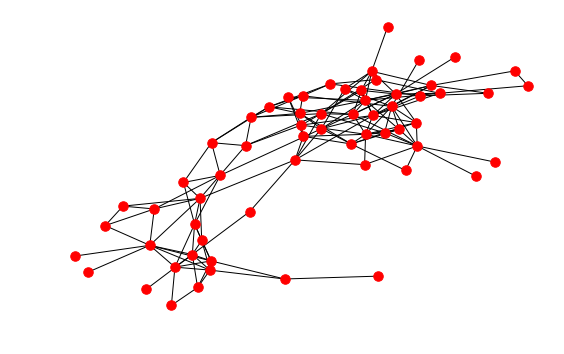

In [3]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=90)
plt.show()

Le agregamos el género a los delfines

In [4]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')
data_gender
colores=[]

# Le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
# Creamos un vector de colores que vincula los generos (mismo orden)     
for node in G.node:
    gen = G.node[node]['genero']
    #print(node,gen)
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')

Graficamos el grafo

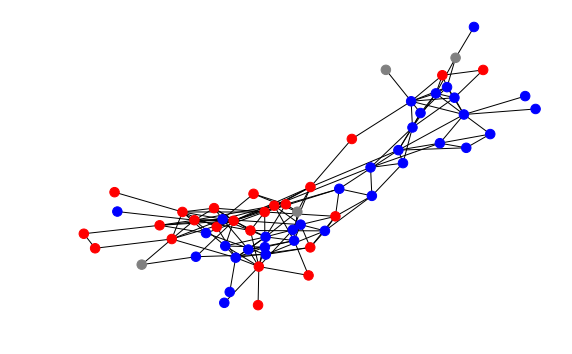

In [5]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_grouping='genero',node_size=90)
plt.show()

# Funcion que calcula particiones

In [6]:
def clusterize(nx_Graph, method="infomap"):
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        #print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [7]:
colors = ['red','blue','yellow','orange','violet','green','black','grey']

Creamos una función para graficar las redes

In [8]:
def draw_partitions(partition,metodo):
    #drawing
    plt.figure(1,figsize=(10,10)) 
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 160,
                                    node_color = colors[int(count)],alpha=1) 

    nx.draw_networkx_edges(G, pos, alpha=0.1,labels=True)
    plt.axis('off')
    pylab.savefig('partition_%s.eps'%metodo,format='eps', dpi=300, bbox_inches='tight')
    plt.show()

# Clustering por Louvain

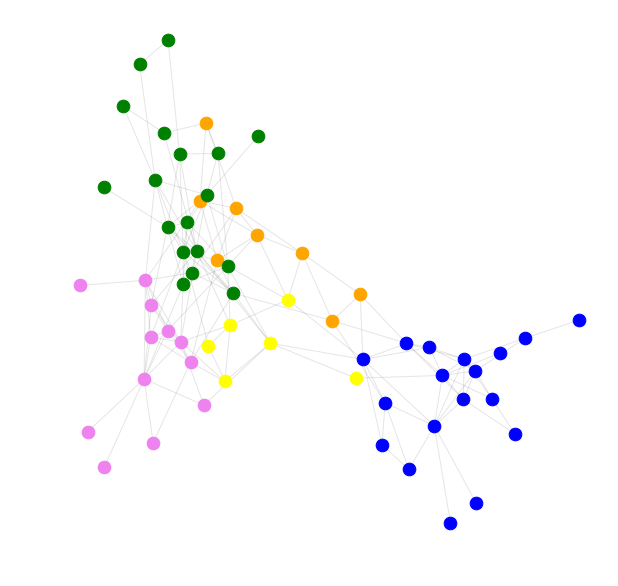

In [9]:
partition_louvain = clusterize(G, method="louvain")
draw_partitions(partition_louvain,"louvain")

# Clustering por Edge Betweenness

In [10]:
partition_edge_betweennes = clusterize(G, method="edge_betweenness")

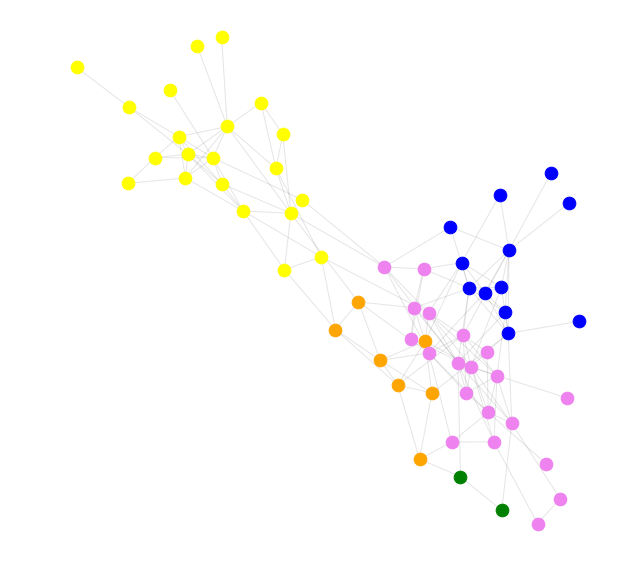

In [11]:
draw_partitions(partition_edge_betweennes,"edge_betweenness")

# Clustering por Fast Greedy

In [12]:
partition_fast_greedy = clusterize(G, method="fastgreedy")

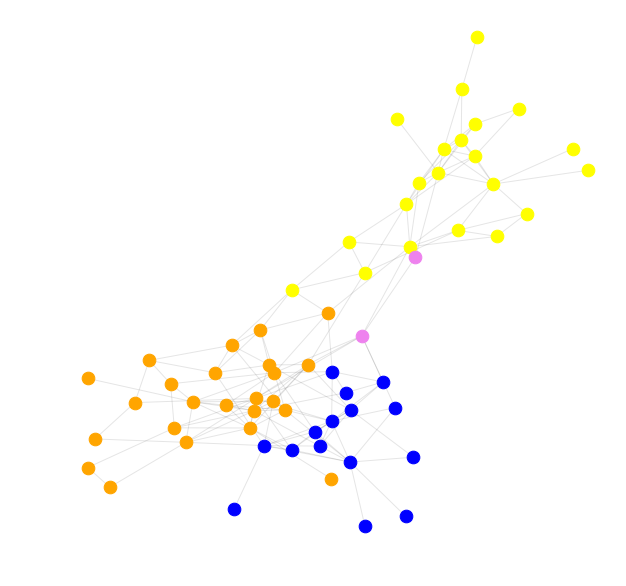

In [13]:
draw_partitions(partition_fast_greedy,"fastgreedy")

# Clustering por Infomap

In [14]:
partition_infomap = clusterize(G, method="infomap")

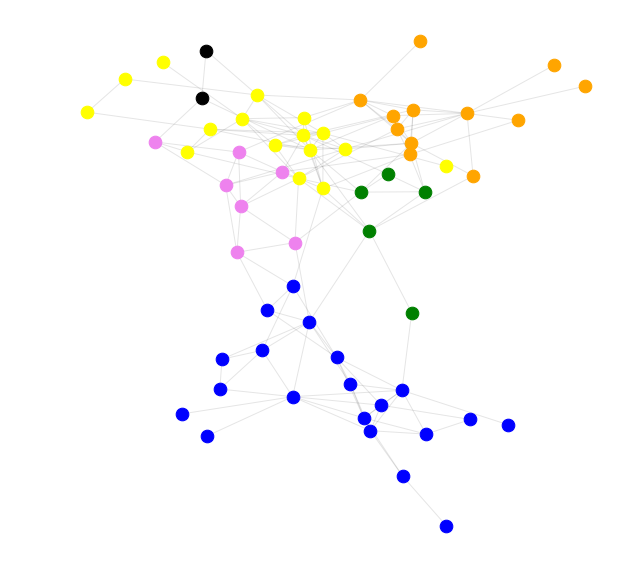

In [15]:
draw_partitions(partition_infomap,"infomap")

## Calculo de modularidad

In [16]:
def modularity(red,partition):
    m = red.number_of_edges()
    A = nx.adjacency_matrix(red)
    v = 0
    sumando=0.0
    l = red.number_of_nodes()
    while v < l:      # Loop de nodo v
        node_v = list(red)[v]
        if node_v in partition:
            partition_v = int(partition[node_v])
            w=0
            while w < l:  # Loop de nodo w
                node_w = list(red)[w]
                if node_w in partition:
                    partition_w = int(partition[node_w])
                    if( partition_v==partition_w and node_v != node_w):
                        kv = int(red.degree()[node_v])
                        kw = int(red.degree()[node_w])
                        sumando+= A[v,w] - (kv*kw)/(2*m)
                w+=1
        v+=1
    modularity = sumando/(2*m)
    return modularity

In [17]:
def random_modularities(red,metodo):
    metodo =  str(metodo)
    copia_red = red.copy()
    partition = clusterize(copia_red, method=metodo)
    modularity_original = modularity(red,partition)
    it_max =100
    it = 0
    array_modularity =[]
    m = red.number_of_edges()
    while it< it_max: 
        red_recableada = nx.double_edge_swap(copia_red, nswap=m, max_tries=1000)
        partition = clusterize(red_recableada, method=metodo)
        if (max(partition.values())>0):
            array_modularity += [modularity(red_recableada,partition)]
        copia_red = red_recableada
        it+=1
        
    ### PLOT ###
    cantidad_bins = 30
    xmin = 0.2
    xmax = 1.0
    plt.axvline(x=modularity_original,color ='r')
    weights = np.ones_like(array_modularity)/float(len(array_modularity))
    #plt.hist(array_modularity,list(np.linspace(xmin,xmax,cantidad_bins)),weights=weights)
    plt.hist(array_modularity)
    plt.xlabel('Modularity')
    plt.ylabel('Frecuency')
    #pylab.xlim(0.2, 1.0)
    #pylab.ylim(0, 0.32)
    pylab.savefig('histo_%s.eps'%metodo,format='eps', dpi=300, bbox_inches='tight')
    plt.show()    

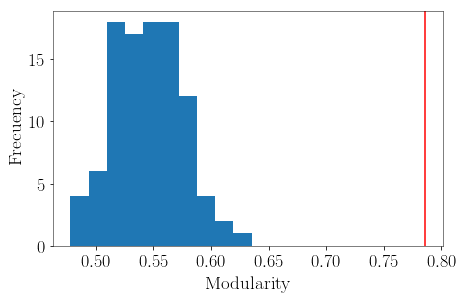

In [18]:
random_modularities(G,"louvain")

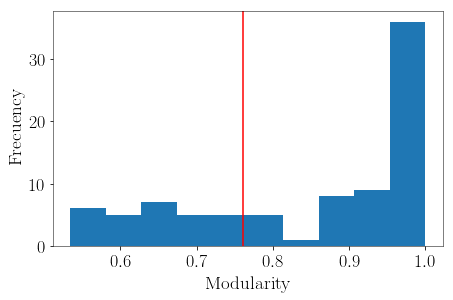

In [19]:
random_modularities(G,"infomap")

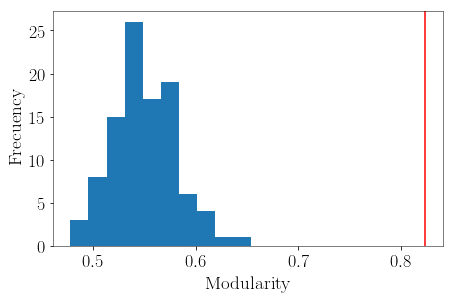

In [20]:
random_modularities(G,"fastgreedy")

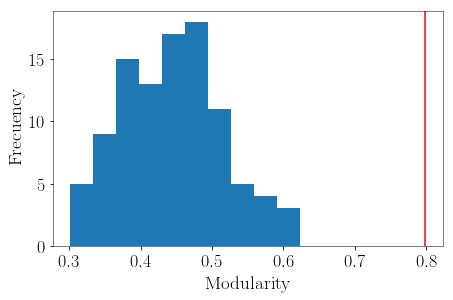

In [21]:
random_modularities(G,"edge_betweenness")

# Calculo Silhouette

Calculamos la cantidad de nodos en cada comunidad

In [22]:
def analisis_comunidades(red,partition):
    l = red.number_of_nodes()
    i = 0
    comunidades = 0
    while i < l:
        nombre_nodo_i = list(red)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        if comunidad_nodo_i > comunidades:
            comunidades = comunidad_nodo_i
        i+=1
    comunidades += 1    
    
    i = 0
    nodos_comunidades= np.zeros(comunidades)
    while i < l:
        nombre_nodo_i = list(red)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        nodos_comunidades[comunidad_nodo_i] += 1
        i+=1
        
    return (comunidades,nodos_comunidades)

Creamos una función para calcular el coeficiente de Silhouette

In [23]:
def Silhouette_Coefficient(red,partition):
    copia_red=red.copy()
    l = copia_red.number_of_nodes()
    i = 0
    comunidades = analisis_comunidades(copia_red,partition)[0]
    nodos_comunidades = analisis_comunidades(copia_red,partition)[1]
    s = []

    while i < l:
        nombre_nodo_i = list(copia_red)[i]
        camino_comunidad= np.zeros(comunidades)
        comunidad_nodo_i = partition[nombre_nodo_i]
        distancia_i_comunidad = []
        j = 0
        while j < l:
            nombre_nodo_j = list(copia_red)[j]
            comunidad_nodo_j = partition[nombre_nodo_j]
            
            if i!=j:
                if comunidad_nodo_i == comunidad_nodo_j:
                    camino = nx.shortest_path_length(copia_red,source=nombre_nodo_i,target=nombre_nodo_j)
                    distancia_i_comunidad +=[camino] 
                else:
                    camino = nx.shortest_path_length(copia_red,source=nombre_nodo_i,target=nombre_nodo_j)
                    camino_comunidad[comunidad_nodo_j] += camino
            j+=1

        if distancia_i_comunidad != []:  #si pertenece a un cluster que tiene mas de un nodo
            distancia_cluster_propio = np.mean(distancia_i_comunidad)  
        else:
            distancia_cluster_propio = 0.0
            
        distancia_clusters_vecinos = camino_comunidad/nodos_comunidades
        
        #print(i+1,distancia_cluster_propio,distancia_clusters_vecinos,comunidades,nodos_comunidades,camino_comunidad)
        if comunidades > 1:
            distancia_cluster_mas_cercano = np.min(distancia_clusters_vecinos[np.nonzero(distancia_clusters_vecinos)])
            #print(distancia_cluster_mas_cercano)
            numerador = distancia_cluster_mas_cercano - distancia_cluster_propio
            denominador = np.maximum(distancia_cluster_mas_cercano,distancia_cluster_propio)
        
            s+=[numerador/denominador]

        i+=1

    return (s,comunidades)

In [24]:
Resultado_grafo_original_edge_betweennes = Silhouette_Coefficient(G,partition_edge_betweennes)
Silhouette_Coefficient_edge_betweennes = np.mean(Resultado_grafo_original_edge_betweennes[0])
Comunidades_original_edge_betweennes = Resultado_grafo_original_edge_betweennes[1]

In [25]:
Resultado_grafo_original_fast_greedy = Silhouette_Coefficient(G,partition_fast_greedy)
Silhouette_Coefficient_fast_greedy = np.mean(Resultado_grafo_original_fast_greedy[0])
Comunidades_original_fast_greedy = Resultado_grafo_original_fast_greedy[1]

In [26]:
Resultado_grafo_original_infomap = Silhouette_Coefficient(G,partition_infomap)
Silhouette_Coefficient_infomap = np.mean(Resultado_grafo_original_infomap[0])
Comunidades_original_infomap = Resultado_grafo_original_infomap[1]

In [27]:
Resultado_grafo_original_louvain = Silhouette_Coefficient(G,partition_louvain)
Silhouette_Coefficient_louvain = np.mean(Resultado_grafo_original_louvain[0])
Comunidades_original_louvain = Resultado_grafo_original_louvain[1]

In [28]:
data = pd.DataFrame({" ":["Edge Betweennes",'Fast Greedy','Infomap','Louvain'],
                     "Silhoutte":[round(Silhouette_Coefficient_edge_betweennes,2),round(Silhouette_Coefficient_fast_greedy,2),round(Silhouette_Coefficient_infomap,2),round(Silhouette_Coefficient_louvain,2)],
                     })
data

,,Silhoutte
0,Edge Betweennes,0.29
1,Fast Greedy,0.14
2,Infomap,0.26
3,Louvain,0.26


Creamos una función para analizar cómo se modifican las particiones al recablear la red.

In [29]:
def Silhoutte_recableado(red):
    it = 100
    i = 0
    silhoutte_recableado_edge_betweennes = []
    silhoutte_recableado_fast_greedy = []
    silhoutte_recableado_infomap = []
    silhoutte_recableado_louvain = []
    comunidades_recableado_edge_betweennes = []
    comunidades_recableado_fast_greedy = []
    comunidades_recableado_infomap = []
    comunidades_recableado_louvain = []
    #copia_red=red.copy()
    copia_red = red
    
    comp_gigante_original = max(nx.connected_component_subgraphs(red), key=len)
    len_comp_gigante_original = len(comp_gigante_original)
    
    while i < it:
        nueva_red = nx.double_edge_swap(copia_red, nswap=copia_red.number_of_edges(), max_tries=1000)
        
        comp_gigante_recableada = max(nx.connected_component_subgraphs(nueva_red), key=len)
        len_comp_gigante_recableada = len(comp_gigante_recableada)
        
        if len_comp_gigante_original == len_comp_gigante_recableada:
        
            partition_infomap_recableado = clusterize(nueva_red, method="infomap")
            partition_fast_greedy_recableado = clusterize(nueva_red, method="fastgreedy")
            partition_louvain_recableado = clusterize(nueva_red, method="louvain")
            partition_edge_betweennes_recableado = clusterize(nueva_red, method="edge_betweenness")

            resultado_edge_betweennes = Silhouette_Coefficient(nueva_red,partition_edge_betweennes_recableado)
            resultado_fast_greedy = Silhouette_Coefficient(nueva_red,partition_fast_greedy_recableado)
            resultado_infomap = Silhouette_Coefficient(nueva_red,partition_infomap_recableado)
            resultado_louvain = Silhouette_Coefficient(nueva_red,partition_louvain_recableado)
            
            comunidades_edge_betweennes = resultado_edge_betweennes[1]
            comunidades_fast_greedy = resultado_fast_greedy[1]
            comunidades_infomap = resultado_infomap[1]
            comunidades_louvain = resultado_louvain[1]
            
            if comunidades_edge_betweennes > 1:
                silhoutte_recableado_edge_betweennes += [np.mean(resultado_edge_betweennes[0])]
                comunidades_recableado_edge_betweennes += [comunidades_edge_betweennes]
            if comunidades_fast_greedy > 1:
                silhoutte_recableado_fast_greedy += [np.mean(resultado_fast_greedy[0])]
                comunidades_recableado_fast_greedy += [comunidades_fast_greedy]
            if comunidades_infomap > 1:
                silhoutte_recableado_infomap += [np.mean(resultado_infomap[0])]
                comunidades_recableado_infomap += [comunidades_infomap]
            if comunidades_louvain > 1:
                silhoutte_recableado_louvain += [np.mean(resultado_louvain[0])]
                comunidades_recableado_louvain += [comunidades_louvain]
            
            copia_red=nueva_red

        i+=1
        
    return(silhoutte_recableado_edge_betweennes,silhoutte_recableado_fast_greedy,silhoutte_recableado_infomap,silhoutte_recableado_louvain,comunidades_recableado_edge_betweennes,comunidades_recableado_fast_greedy,comunidades_recableado_infomap,comunidades_recableado_louvain)

In [30]:
recableado = Silhoutte_recableado(G)

In [31]:
def plot_histograms_Silhoutte(data,original,titulo):
    cantidad_bins = 30
    plt.axvline(x=original,color ='r')
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data,bins=cantidad_bins,weights=weights)
    pylab.ylim(0, 0.20)
    pylab.xlim(0, 0.4)
    plt.xlabel('Coeficiente Silhoutte')
    plt.ylabel('Frecuency')
    #pylab.savefig('histo_Silhoutte_%s.eps'%titulo,format='eps', dpi=300, bbox_inches='tight')
    plt.title(titulo)
    plt.show()

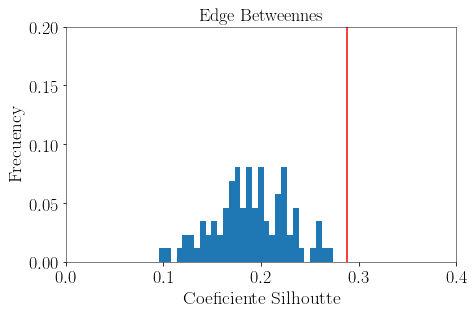

In [32]:
plot_histograms_Silhoutte(recableado[0],Silhouette_Coefficient_edge_betweennes,"Edge Betweennes")

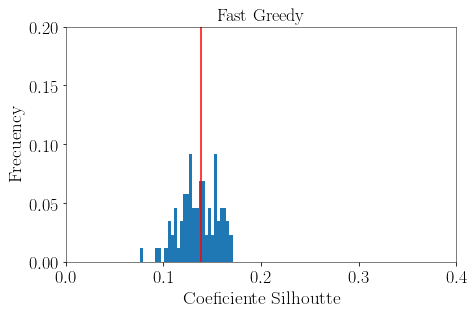

In [33]:
plot_histograms_Silhoutte(recableado[1],Silhouette_Coefficient_fast_greedy,"Fast Greedy")

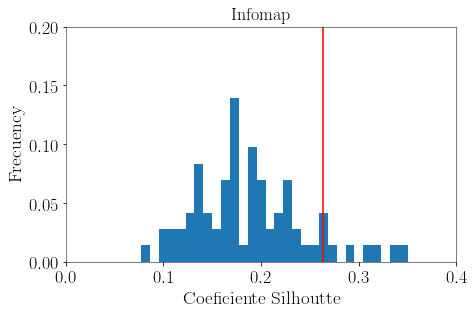

In [34]:
plot_histograms_Silhoutte(recableado[2],Silhouette_Coefficient_infomap,"Infomap")

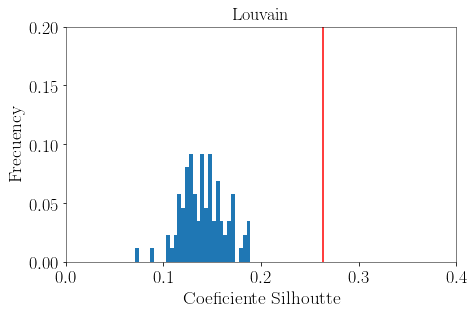

In [35]:
plot_histograms_Silhoutte(recableado[3],Silhouette_Coefficient_louvain,"Louvain")

Graficamos la cantidad de particiones para los diferentes algoritmos utilizados.

In [37]:
def plot_histograms_Silhoutte_comunities(data,original,titulo):
    cantidad_bins = 35
    plt.axvline(x=original,color ='r')
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data,bins=cantidad_bins,weights=weights)
    #pylab.ylim(0, 0.55)
    pylab.xlim(0, 35)
    plt.xlabel('Number of partitions')
    plt.ylabel('Frecuency')
    #pylab.savefig('histo_Silhoutte_comunities_%s.eps'%titulo,format='eps', dpi=300, bbox_inches='tight')
    plt.title(titulo)
    plt.show()

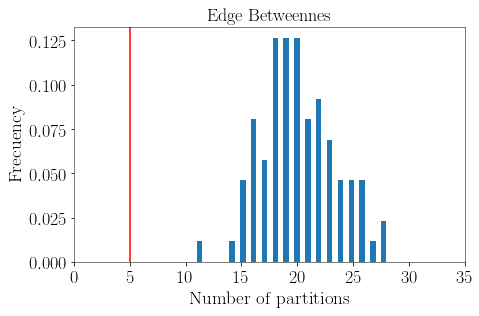

In [38]:
plot_histograms_Silhoutte_comunities(recableado[4],Comunidades_original_edge_betweennes,"Edge Betweennes")
#plot_histograms_Silhoutte_comunities(recableado[5],Comunidades_original_fast_greedy,"Fast Greedy")
#plot_histograms_Silhoutte_comunities(recableado[6],Comunidades_original_infomap,"Infomap")
#plot_histograms_Silhoutte_comunities(recableado[7],Comunidades_original_louvain,"Louvain")

Analizamos si existe alguna correspondencia entre la estructura de comunidades del grupo y el género de los delfines. 

In [39]:
def genero_particiones(red,metodo):
    metodo =  str(metodo)
    copia_red = red.copy()
    partition = clusterize(copia_red, method=metodo)
    comunidades = max(partition.values())+1
    l = copia_red.number_of_nodes()
    machos = np.zeros(comunidades)
    hembras = np.zeros(comunidades)
    fraccion_hembras_comunidad = []
    i = 0
    while i < l:
        nombre_nodo_i = list(copia_red)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        gen = copia_red.node[nombre_nodo_i]['genero']
        if gen=='f':
            hembras[comunidad_nodo_i]+=1
        elif gen=='m':
            machos[comunidad_nodo_i]+=1
        i+=1
    
    i = 0
    delfines_comunidad = hembras + machos
    while i < comunidades:
        if delfines_comunidad[i]>0:
            fraccion_hembras_comunidad += [hembras[i] / delfines_comunidad[i]]
        i+=1
        
    fraccion_promedio_hembras_comunidad = np.mean(fraccion_hembras_comunidad)

    return fraccion_promedio_hembras_comunidad
            

In [40]:
genero_louvain_original = genero_particiones(G,"louvain")
genero_infomap_original = genero_particiones(G,"infomap")
genero_fast_greedy_original = genero_particiones(G,"fastgreedy")
genero_edge_betweenness_original = genero_particiones(G,"edge_betweenness")

In [43]:
def genero_particiones_shuffle(red,metodo):
    metodo =  str(metodo)
    it = 100
    i = 0
    fraccion_hembras_comunidad = []
    copia_red=red.copy()
    #copia_red = red
    nodes = nx.get_node_attributes(red, "genero").values()
    
    while i < it:
        random.shuffle(nodes)
        j = 0
        for n in copia_red: # cambia el genero de los delfines
            copia_red.node[n]['genero']= nodes[j]
            j+=1
        fraccion_hembras_comunidad +=[genero_particiones(copia_red,metodo)] # Array que almacena la fraccion de enlaces hetero para asignaciones random
        i+=1
    
    return fraccion_hembras_comunidad

In [44]:
suffle_louvain = genero_particiones_shuffle(G,"louvain")
suffle_infomap = genero_particiones_shuffle(G,"infomap")
suffle_fast_greedy = genero_particiones_shuffle(G,"fastgreedy")
suffle_edge_betweenness = genero_particiones_shuffle(G,"edge_betweenness")

In [45]:
def plot_histograms_gen_comunities(data,original,titulo):
    cantidad_bins = 30
    plt.axvline(x=original,color ='r')
    weights = np.ones_like(data)/float(len(data))
    plt.hist(data,bins=cantidad_bins,weights=weights)
    pylab.ylim(0, 0.12)
    pylab.xlim(0.1, 0.6)
    plt.xlabel('Female fraction')
    plt.ylabel('Frecuency')
    #pylab.savefig('histo_Female_fraction_comunities_%s.eps'%titulo,format='eps', dpi=300, bbox_inches='tight')
    plt.title(titulo)
    plt.show()

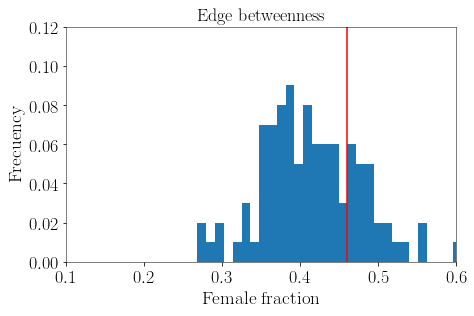

In [46]:
#plot_histograms_gen_comunities(suffle_louvain,genero_louvain_original,"Louvain")
#plot_histograms_gen_comunities(suffle_fast_greedy,genero_fast_greedy_original,"Fast Greedy")
#plot_histograms_gen_comunities(suffle_infomap,genero_infomap_original,"Infomap")
plot_histograms_gen_comunities(suffle_edge_betweenness,genero_edge_betweenness_original,"Edge betweenness")